<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/02_MAB_movielens_egreedy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Arm Bandits - Epsilon Greedy

#### Installation

In [1]:
!rm -f ./utils.py
!wget --no-check-certificate --no-cache --no-cookies \
    https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py \
    -O ./utils.py

--2021-02-25 10:59:20--  https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4245 (4.1K) [text/plain]
Saving to: ‘./utils.py’

./utils.py          100%[===================>]   4.15K  --.-KB/s    in 0s      

2021-02-25 10:59:20 (38.5 MB/s) - ‘./utils.py’ saved [4245/4245]



##### Imports

In [2]:
from tqdm.notebook import trange
from typing import Dict, List, Text, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import zipfile

from utils import load_movielens_data
from utils import plot_accuracy, plot_actions, plot_cumsum, plot_regret

# Apply the default theme
sns.set_theme()

#### Downloading the [MovieLens](https://grouplens.org/datasets/movielens/) (100K) dataset.

**Dataset info**

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.

This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies.
* Each user has rated at least 20 movies.
* Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th,
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.

In [3]:
print("Downloading movielens data...")

!wget --no-check-certificate \
    http://files.grouplens.org/datasets/movielens/ml-100k.zip \
    -O ./movielens.zip

zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info').decode())

--2021-02-25 10:59:21--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘./movielens.zip’

./movielens.zip     100%[===================>]   4.70M  16.2MB/s    in 0.3s    

2021-02-25 10:59:21 (16.2 MB/s) - ‘./movielens.zip’ saved [4924029/4924029]

Done. Dataset contains:
943 users
1682 items
100000 ratings



#### Parameters -- Feel Free to Play Around

In [4]:
RANK_K = 20 # @param {type:"integer"}
NUM_ACTIONS = 20 # @param {type:"integer"}

## Environment

Implementation of the environment uses **MovieLens 100K dataset**. As described above, the dataset contains 100000 ratings from 943 users and 1682 movies. The environment can consider only the first $n$ of the dataset's movies. It can be set-up by `num_actions`. The number of "known" movies for the environment is equal to actions/arms.

> Users without a rating (after selecting first $n$ movies) are removed from the environment.

> In every step, the batch of users will be selected randomly.

In [5]:
class MovielensEnvironment(object):
  def __init__(
      self, 
      data_dir: Text,
      rank_k: int, 
      batch_size: int = 1,
      num_movies: int = 20
  ):
    """Initializes the MovieLens Bandit environment.
    Args:
      data_dir: (string) Directory where the data lies (in text form).
      rank_k : (int) Which rank to use in the matrix factorization.
      batch_size: (int) Number of observations generated per call.
      num_movies: (int) Only the first `num_movies` movies will be used by the
        environment. The rest is cut out from the data.
    """
    self._num_actions = num_movies
    self._batch_size = batch_size
    self._context_dim = rank_k

    # Compute the matrix factorization.
    self._data_matrix = load_movielens_data(data_dir)
    # Keep only the first items.
    self._data_matrix = self._data_matrix[:, :num_movies]
    # Filter the users with no iterm rated.
    nonzero_users = list(np.nonzero(np.sum(self._data_matrix, axis=1) > 0.0)[0])
    self._data_matrix = self._data_matrix[nonzero_users, :]
    self._effective_num_users = len(nonzero_users)

    # Compute the SVD.
    u, s, vh = np.linalg.svd(self._data_matrix, full_matrices=False)
    # Keep only the largest singular values.
    self._u_hat = u[:, :rank_k] * np.sqrt(s[:rank_k])
    self._v_hat = np.transpose(
        np.transpose(vh[:rank_k, :]) * np.sqrt(s[:rank_k]))
    self._approx_ratings_matrix = np.matmul(self._u_hat, self._v_hat)

    self._current_users = np.zeros(batch_size)
    self._previous_users = np.zeros(batch_size)

    self._optimal_action_table = np.argmax(
        self._approx_ratings_matrix, axis=1)
    self._optimal_reward_table = np.max(
        self._approx_ratings_matrix, axis=1)
    
    #self._params = params
    #self._observe()
    self.reset()

  @property
  def batch_size(self):
    return self._batch_size

  @property
  def best_arm(self) -> int:
    return np.argmax(np.sum(env._data_matrix, axis=0))

  @property
  def n_arms(self) -> int:
    return self._data_matrix.shape[1]

  def reset(self):
    return self._observe()

  def _observe(self) -> np.ndarray:
    """Returns the u vectors of a random sample of users."""
    sampled_users = random.sample(
        range(self._effective_num_users), self._batch_size)
    self._previous_users = self._current_users
    self._current_users = sampled_users
    batched_observations = self._u_hat[sampled_users]
    return batched_observations

  def step(self, action: List[int]) -> Tuple[int, float]:
    """Computes the reward for the input actions."""
    rewards = []
    for i, j in zip(self._current_users, action):
      rewards.append(self._approx_ratings_matrix[i, j])
    return np.array(rewards)
  
  def best_action(self):
    return np.argmax(self._params)

  def compute_optimal_action(self):
    return self._optimal_action_table[self._previous_users]

  def compute_optimal_reward(self):
    return self._optimal_reward_table[self._previous_users]

In [6]:
env = MovielensEnvironment('./ml-100k/u.data', rank_k=20, batch_size=1, num_movies=20)
env.step([4])

array([-1.00220682e-15])

In [7]:
env.reset()

action = np.zeros(1, dtype=np.int32)
reward = env.step(action)

print(f'Action={action} (optimal={env.compute_optimal_action()})')
print(f'Reward={reward} (optimal={env.compute_optimal_reward()})')

print(f'best_arm={env.best_arm}')

Action=[0] (optimal=[0])
Reward=[1.36643908e-14] (optimal=[4.])
best_arm=0


## Policy

In [8]:
class EpsilonGreedyPolicy(object):
  def __init__(self, epsilon: float, values: List[float], batch_size: int = 1):
    self._epsilon = epsilon
    self._values = values

    self._batch_size = batch_size

  def action(self) -> int:
    val_max = max(self._values)

    ret = []

    for rnd in np.random.rand(self._batch_size):
      if rnd > self._epsilon:
        ret.append(np.random.choice(
            [i for i, val in enumerate(self._values) if val == val_max]))
      else:
        ret.append(np.random.randint(len(self._values)))
    
    return ret

In [9]:
p = EpsilonGreedyPolicy(epsilon=0.1, values=[1, 2, 3], batch_size=10)
print(f'E-Greedy - action:{p.action()}')

E-Greedy - action:[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


## Agent

In [10]:
class EpsilonGreedyAgent(object):
  
  def __init__(self, n: int, epsilon: float = 0.1, batch_size: int = 1):
    self._epsilon = epsilon
    self._n = n
    self._batch_size = batch_size

    self.reset()

    self.policy = EpsilonGreedyPolicy(
        self._epsilon, self._values, batch_size=batch_size)

  def reset(self):
    self._counts = [0] * self._n
    self._values = [0.0] * self._n

  def train(self, experience: Dict[str, float]):
    action = experience['action']
    reward = experience['reward']

    self._counts[action] += 1

    value = self._values[action]
    n = self._counts[action]

    self._values[action] = ((n - 1) / n) * value + (1 / n) * reward

In [11]:
ag = EpsilonGreedyAgent(3)

experience = {'action': 2, 'reward': 1}
ag.train(experience)
print(f'values={ag._values}')

experience = {'action': 2, 'reward': 0}
ag.train(experience)
print(f'values={ag._values}')

values=[0.0, 0.0, 1.0]
values=[0.0, 0.0, 0.5]


## Training

In [12]:
def run(environment: object, agent: object, trials=100):
  trajectory = []

  experience = {
      'trial': 0, 
      'action': -1, 
      'observation': 0, 
      'reward': 0,
      'regret': -1
  }

  for i in range(trials):
    experience['trial'] = i + 1
    actions = agent.policy.action()
    rewards = environment.step(actions)
    optimal_rewards = environment.compute_optimal_reward()

    for action, reward, optimal_reward in zip(actions, rewards, optimal_rewards):
      experience['action'] = action
      experience['reward'] = reward
      experience['regret'] = optimal_reward - reward

      agent.train(experience)

      #df_trajectory = df_trajectory.append(experience, ignore_index=True)
      trajectory.append(experience.copy())
    
  df_trajectory = pd.DataFrame.from_dict(trajectory)
  df_cumsum = df_trajectory.groupby('action')['reward'].cumsum()
  df_trajectory = df_trajectory.assign(cum_sum=df_trajectory['reward'].cumsum())
  df_trajectory = df_trajectory.assign(action_cum_sum=df_cumsum)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'})

In [13]:
batch_size =   32 # @param {type:"integer"}
epsilon = 0.1 # @param {type: "number"}
num_iterations =   150 # @param {type:"integer"}

environment = MovielensEnvironment(
    './ml-100k/u.data', 
    rank_k=RANK_K, 
    batch_size=batch_size, 
    num_movies=NUM_ACTIONS)
step = environment.reset()

agent = EpsilonGreedyAgent(
    environment.n_arms, 
    epsilon=epsilon, 
    batch_size=environment.batch_size)
experience = {'action': [-1], 'reward': [0]}

df_trajectory = run(environment, agent, trials=num_iterations)

print(f'\nvalues={agent._values}')
print(f'\nvalues={agent._counts}')
print(
  f'best action={np.argmax(agent._values)} '
  f'(environment best_action={environment.best_arm})'
)


values=[2.5822996183206164, 0.9166666666666595, 0.39393939393939287, 0.5238095238095122, 0.47826086956521313, 0.7346938775510216, 0.49999999999999706, 1.4821428571428534, 1.3181818181818266, 1.1818181818181839, 1.5399999999999825, 1.49999999999998, 1.0400000000000058, 0.6285714285714424, 1.5892857142857342, 1.3861876790501126e-15, 0.8399999999999941, 8.900683674032555e-16, 0.10344827586207432, 0.4901960784313763]

values=[4192, 24, 33, 21, 23, 49, 20, 56, 22, 22, 50, 22, 25, 35, 56, 22, 25, 23, 29, 51]
best action=0 (environment best_action=0)


Now let's see the result. After running the last code snippet, the resulting plot (hopefully) shows that the average regret is going down as the agent is trained and the policy gets better in figuring out what the right action is, given the observation.

In [14]:
params = {
  'algorithm': 'E-Greedy',
  'best_action': environment.best_arm
}

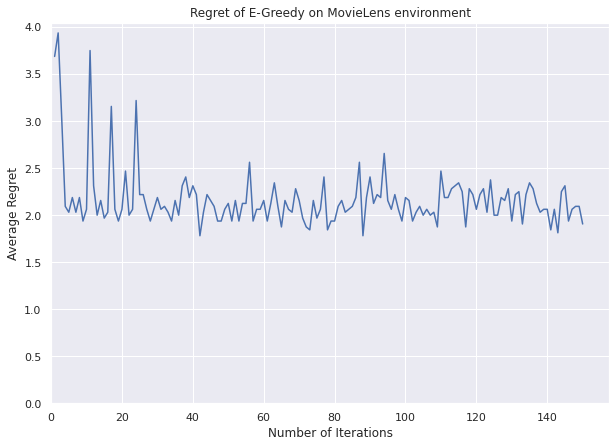

In [15]:
plot_regret(df_trajectory.groupby('trial').mean()['regret'], params)

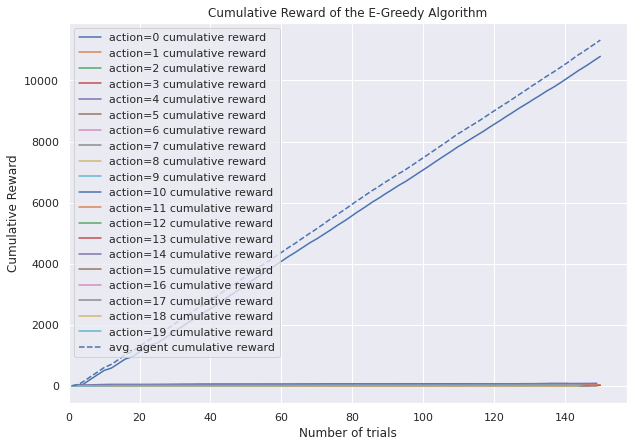

In [16]:
plot_cumsum(df_trajectory.copy(), params, show_actions=True)

#### Multiple runs

In [17]:
def experiment(epsilons: List[float], epochs: int = 1, trials: int = 10, batch_size: int = 1):
  trajectories = []
  
  environment = MovielensEnvironment(
      './ml-100k/u.data', 
      rank_k=RANK_K, 
      batch_size=batch_size, 
      num_movies=NUM_ACTIONS)
  params = {'best_action': environment.best_arm}
  
  for epsilon in epsilons:
    for epoch in trange(epochs):
      step = environment.reset()
      agent = EpsilonGreedyAgent(
          environment.n_arms, 
          epsilon=epsilon, 
          batch_size=environment.batch_size)
      
      df = run(environment, agent, trials=trials)
      df['epoch'] = epoch + 1
      df['epsilon'] = epsilon
      #df['best action'] = np.argmax(agent._values)

      #print(df)

      trajectories.append(df)

  df_trajectory = pd.concat(trajectories, ignore_index=True)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'}), params

In [18]:
batch_size =   256 # @param {type:"integer"}
epochs =  25# @param {type: "integer"}
num_iterations =   150 # @param {type:"integer"}

df_trajectory, params = experiment(
    epsilons=[0.1], 
    epochs=epochs, 
    trials=num_iterations, 
    batch_size=batch_size)

Now let's see the average results after running multiple runs. The resulting regret plot (hopefully) shows that the average regret is going down as the agent is trained and the policy gets better in figuring out what the right action is, given the observation.

In [20]:
params['algorithm'] = 'E-Greedy'

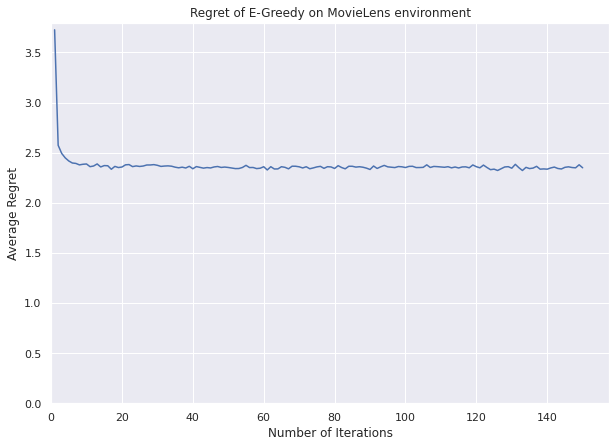

In [21]:
plot_regret(df_trajectory.groupby('trial').mean()['regret'], params)

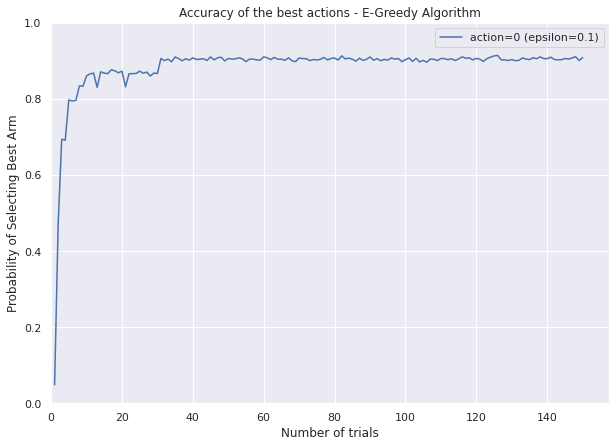

In [22]:
plot_accuracy(df_trajectory, params)

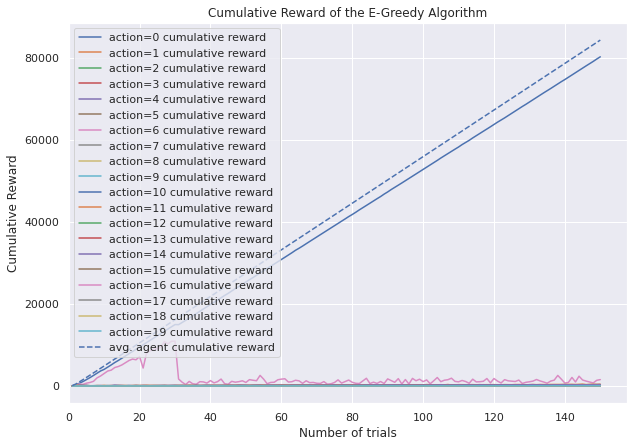

In [23]:
plot_cumsum(df_trajectory[df_trajectory.epsilon == 0.1], params, show_actions=True)

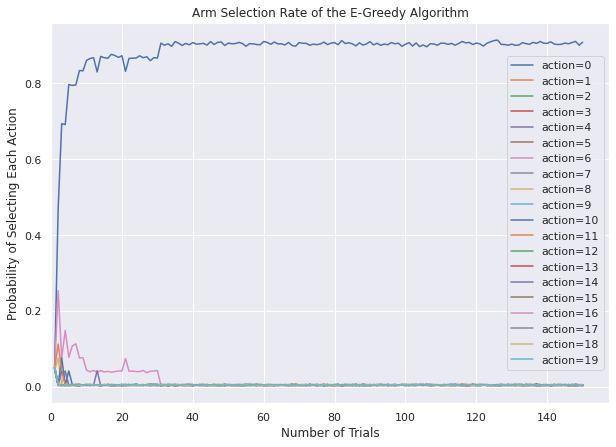

In [24]:
plot_actions(df_trajectory[df_trajectory.epsilon == 0.1], params)